In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import boxcox, skew
%matplotlib inline

In [2]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

In [3]:
ID = test.id
loss = train.loss

train = train.drop(['id','loss'], axis=1)
test = test.drop(['id'], axis=1)

ntrain = train.shape[0]
ntest = test.shape[0]

all_data = pd.concat((train, test)).reset_index(drop=True)

In [4]:
all_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 313864 entries, 0 to 313863
Columns: 130 entries, cat1 to cont14
dtypes: float64(14), object(116)
memory usage: 311.3+ MB


In [5]:
cat_cols = [x for x in all_data.select_dtypes(include=['object']).columns]
cont_cols = [x for x in all_data.select_dtypes(exclude=['object']).columns]

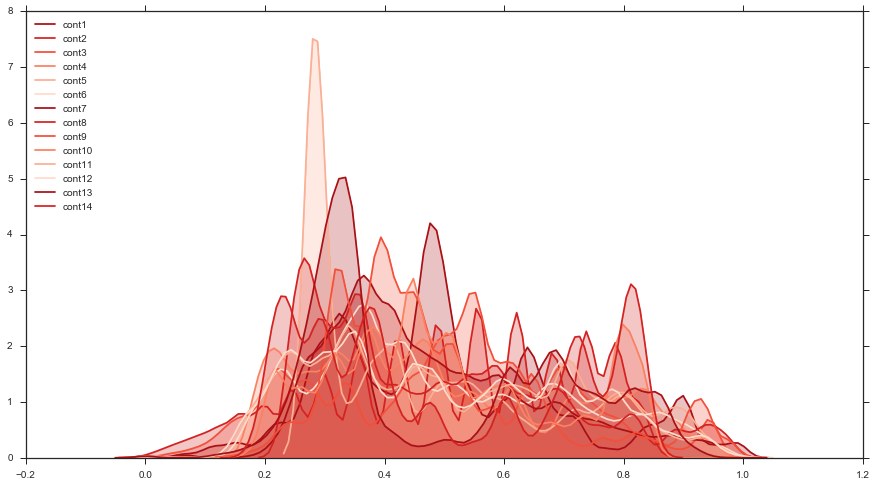

In [6]:
sns.set_style('ticks')
with sns.color_palette('Reds_r'):
    plt.figure(figsize=(15,8))
    for column in cont_cols:
        sns.kdeplot(all_data[column], shade=True)
        plt.legend(loc=2)

As it can be seen from the above kernel density plot that the distribution of the continuous variables is not uniform.
Hence we need to do transformation of this data using either boxcox or natural logarithm in order to make the data more normally distributed.

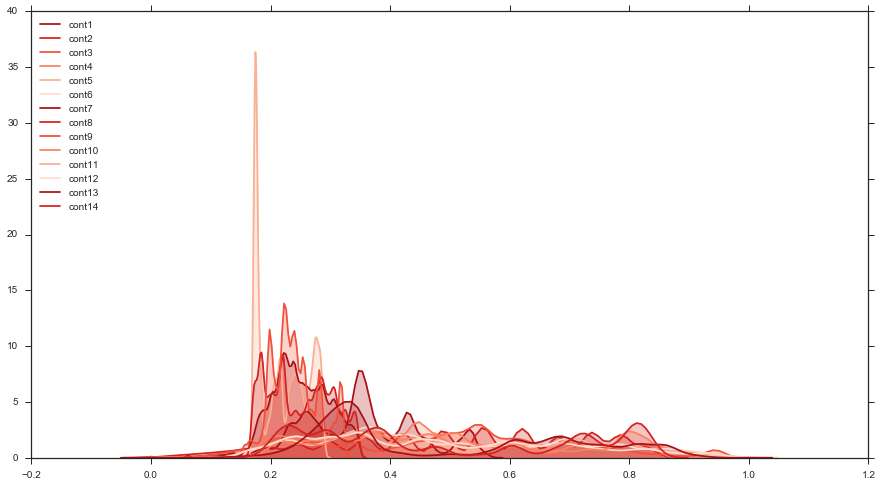

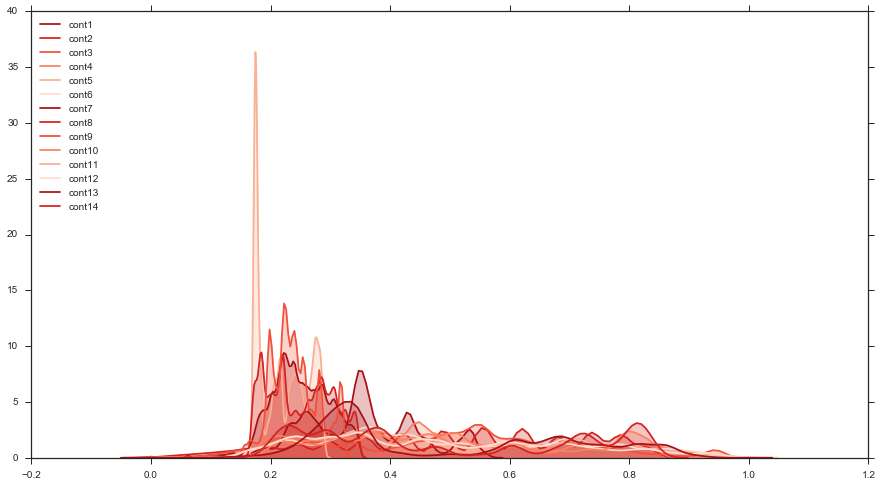

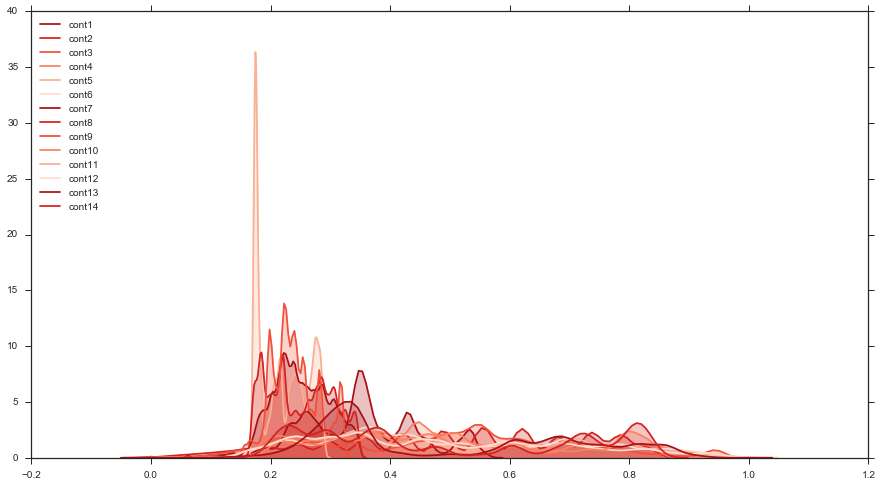

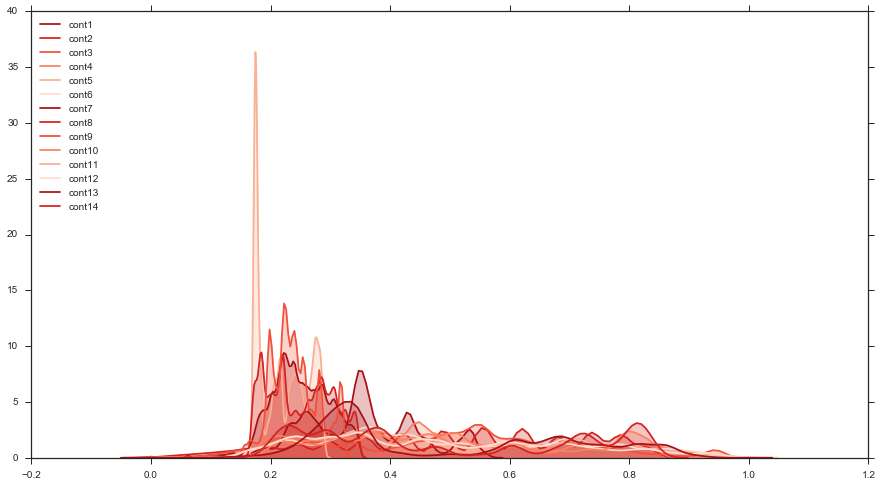

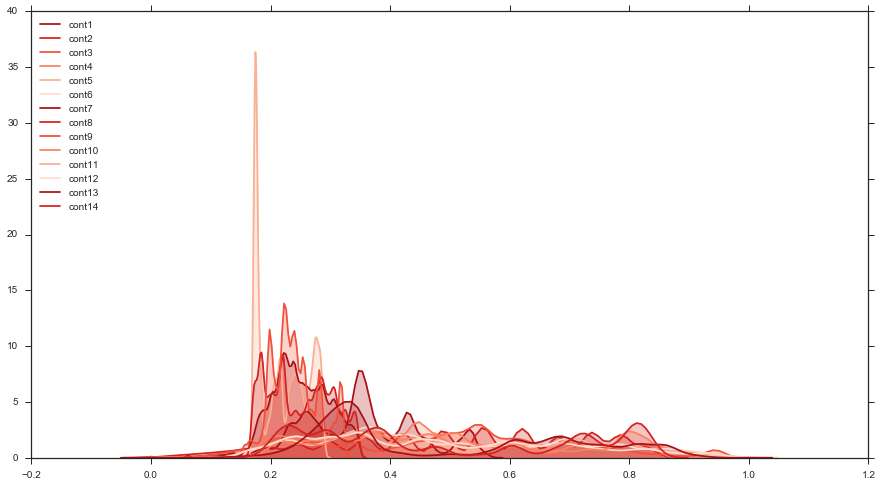

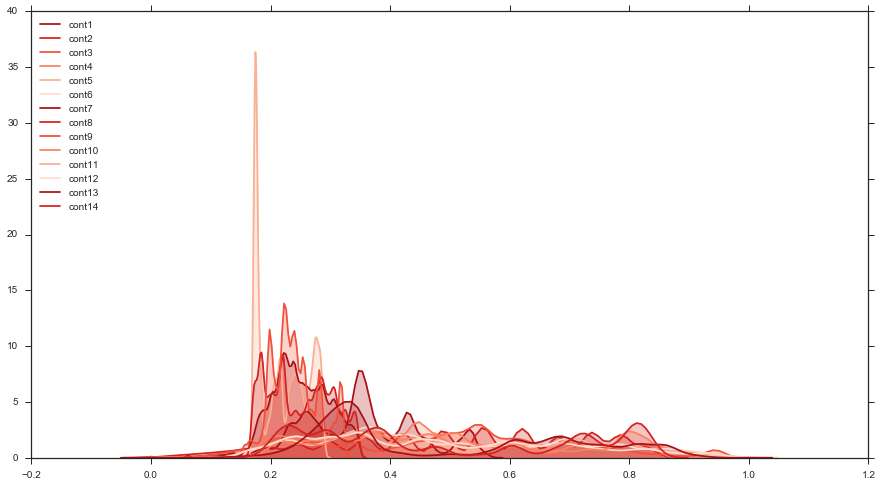

In [7]:
## Experiment on different values for skewed feats
values = [0.1,0.15,0.25,0.35,0.45,0.5]
for value in values:
    df = pd.DataFrame()
    for column in cont_cols:
        df[column] = all_data[column]
    new_feats = df[cont_cols].apply(lambda x: skew(x.dropna()))
    new_feats = new_feats[new_feats > 0.5]
    new_feats = new_feats.index 

    for feature in new_feats:
        df[feature] = df[feature] + 1 
        df[feature], lam = boxcox(df[feature])

    sns.set_style('ticks')
    with sns.color_palette('Reds_r'):
        plt.figure(figsize=(15,8))
        for column in cont_cols:
            sns.kdeplot(df[column], shade=True)
            plt.legend(loc=2)
    del df    

In [6]:
## Find the skewed features
skewed_feats = all_data[cont_cols].apply(lambda x: skew(x.dropna()))
print(skewed_feats)

cont1     0.513205
cont2    -0.311146
cont3    -0.007023
cont4     0.417559
cont5     0.679610
cont6     0.458413
cont7     0.825889
cont8     0.673237
cont9     1.067247
cont10    0.352116
cont11    0.281139
cont12    0.291997
cont13    0.376138
cont14    0.250673
dtype: float64


In [7]:
skewed_feats = skewed_feats[skewed_feats > 0.25]
print(skewed_feats)

cont1     0.513205
cont4     0.417559
cont5     0.679610
cont6     0.458413
cont7     0.825889
cont8     0.673237
cont9     1.067247
cont10    0.352116
cont11    0.281139
cont12    0.291997
cont13    0.376138
cont14    0.250673
dtype: float64


In [8]:
skewed_feats = skewed_feats.index     ## get the column names of the skewed features

## Check for lambda values after applying boxcox. If they are near to zero, then natural log would have done 
## the equivalent transformation.
print("Lambda Values : ")
for feature in skewed_feats:
    all_data[feature] = all_data[feature] +1 ## Adding 1 or any other constant makes it sure that all values are +ve
    all_data[feature], lam = boxcox(all_data[feature])
    print(lam)

Lambda Values : 
-0.585084895197
-0.995197981798
-3.00787936887
-0.95237905372
-2.2837778627
-2.27901724839
-2.56311666326
-0.613891833259
-0.437372340485
-0.47055182116
-1.44082551851
-0.898954661384


As you can see the lambda values are not nearvy to zero in most of the cases, hence transforming the data using log transformation would not have been useful in any way. Let us plot the transformed features again to see how the variables are distributed now.

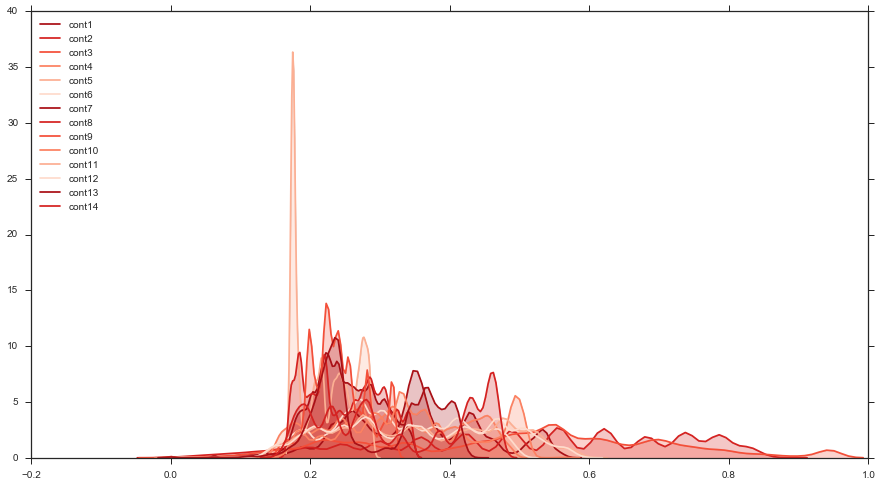

In [11]:
sns.set_style('ticks')
with sns.color_palette('Reds_r'):
    plt.figure(figsize=(15,8))
    for column in cont_cols:
        sns.kdeplot(all_data[column], shade=True)
        plt.legend(loc=2)

In [9]:
# Encode the categorical variables
for column in cat_cols:
    all_data[column] = pd.factorize(all_data[column], sort=True)[0]

x_train = all_data.iloc[:ntrain, :]
x_test = all_data.iloc[ntrain:, :]

In [10]:
print(x_train.shape)
print(x_test.shape)

(188318, 130)
(125546, 130)


In [11]:
## Check for the dimesnions especially for the test set
print(train.shape)
print(test.shape)

(188318, 130)
(125546, 130)


In [12]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

train = scaler.fit_transform(x_train)
test = scaler.fit_transform(x_test)

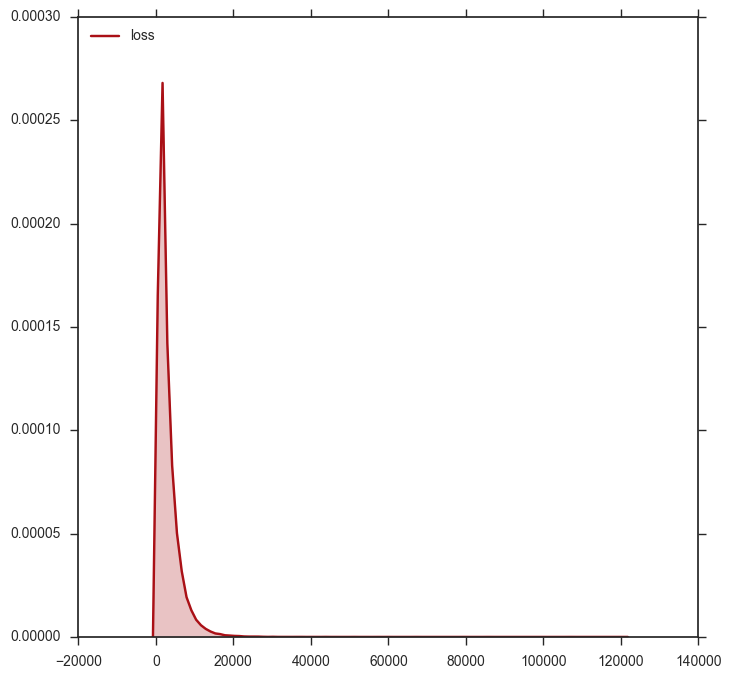

In [13]:
sns.set_style('ticks')
with sns.color_palette('Reds_r'):
    plt.figure(figsize=(8,8))
    sns.kdeplot(loss, shade=True)
    plt.legend(loc=2)

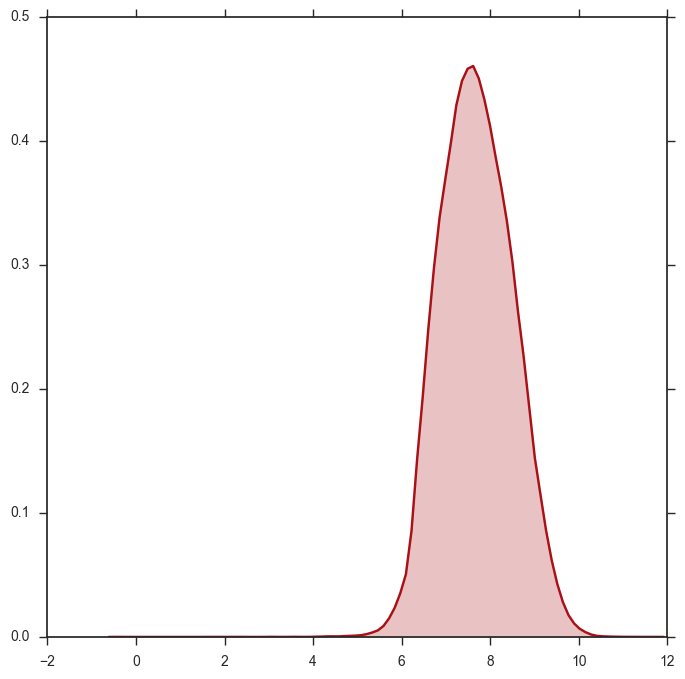

In [13]:
#Take the log transform of the loss 
outcome = np.log(np.array(loss))
sns.set_style('ticks')
with sns.color_palette("Reds_r"):
    plt.figure(figsize=(8,8))
    sns.kdeplot(outcome, shade=True)

In [14]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.grid_search import GridSearchCV

In [17]:
rf_params = {}
rf_params['n_estimators'] = [20,50,100]
rf_params['max_depth'] = [6,8,10]
rf_params['min_samples_leaf'] = [1,2]
rf_params['random_state'] = [111]
rf_params['oob_score'] = [True]

rf_params

{'max_depth': [6, 8, 10],
 'min_samples_leaf': [1, 2],
 'n_estimators': [20, 50, 100],
 'oob_score': [True],
 'random_state': [111]}

In [18]:
rf = RandomForestRegressor(n_estimators =20, max_depth=6, min_samples_leaf=2,random_state=111,oob_score=True)
clf = GridSearchCV(rf,param_grid=rf_params)
clf.fit(x_train,outcome)

C:\Anaconda3\envs\DeepLearning\lib\site-packages\sklearn\ensemble\forest.py:687: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Anaconda3\envs\DeepLearning\lib\site-packages\sklearn\ensemble\forest.py:687: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Anaconda3\envs\DeepLearning\lib\site-packages\sklearn\ensemble\forest.py:687: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Anaconda3\envs\DeepLearning\lib\site-packages\sklearn\ensemble\forest.py:687: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("So

GridSearchCV(cv=None, error_score='raise',
       estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=6,
           max_features='auto', max_leaf_nodes=None, min_samples_leaf=2,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=20, n_jobs=1, oob_score=True, random_state=111,
           verbose=0, warm_start=False),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'max_depth': [6, 8, 10], 'oob_score': [True], 'min_samples_leaf': [1, 2], 'n_estimators': [20, 50, 100], 'random_state': [111]},
       pre_dispatch='2*n_jobs', refit=True, scoring=None, verbose=0)

In [19]:
clf.best_params_

{'max_depth': 10,
 'min_samples_leaf': 2,
 'n_estimators': 100,
 'oob_score': True,
 'random_state': 111}

In [20]:
clf.best_score_

0.48461921941398672

In [19]:
ab_params = {}
ab_params['n_estimators'] = [100,200]
ab_params['learning_rate'] = [0.5, 1]
ab_params['random_state'] = [111]

In [20]:
ab = AdaBoostRegressor()
abReg = GridSearchCV(ab, param_grid=ab_params)
abReg.fit(x_train, outcome)

GridSearchCV(cv=None, error_score='raise',
       estimator=AdaBoostRegressor(base_estimator=None, learning_rate=1.0, loss='linear',
         n_estimators=50, random_state=None),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'n_estimators': [100, 200], 'learning_rate': [0.5, 1], 'random_state': [111]},
       pre_dispatch='2*n_jobs', refit=True, scoring=None, verbose=0)

In [21]:
abReg.best_params_

{'learning_rate': 0.5, 'n_estimators': 100, 'random_state': 111}